# Seismic waveform classification.
In this notebook, a sample of 3D seismic and an interpreted horizon are loaded into Xarray, a tool created specifically for handling multiattribute multidimensional arrays. Each seismic trace is masked outside of a 5 sample (20 ms) window below and above the horizon of interest. Each trace is then datumed for equal comparison assigned to a class by means of k-means unsupervised classification. Finally, the classes are reassigned to their X and Y origin and displayed on a map. At the end, I have included some principal component analysis etc.

Install/import necessary libraries, packages and dependencies.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
!pip install xarray
!pip install obspy
import xarray as xr
from obspy.io.segy.segy import _read_segy
import warnings
warnings.filterwarnings('ignore')

# Import 3D seismic and display:

In [28]:
stream = _read_segy('pnbsct_seis_il_xl_step_1.sgy', headonly=True)
data = np.stack(t.data for t in stream.traces)
print('data:', data.shape)  # traces, time samples

data: (56726, 176)


Reshape traces into a 3D data cube and plot a trace.

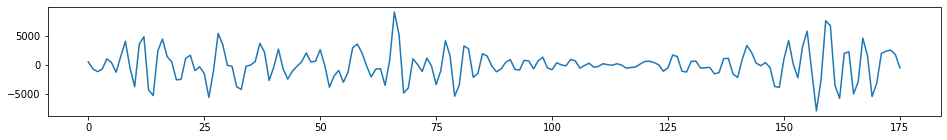

In [29]:
obspycube = np.reshape(data,(226, 251, 176))
plt.figure(figsize=(16,2))
plt.plot(obspycube[1,1,:].data)
plt.show()

Plot a seismic line

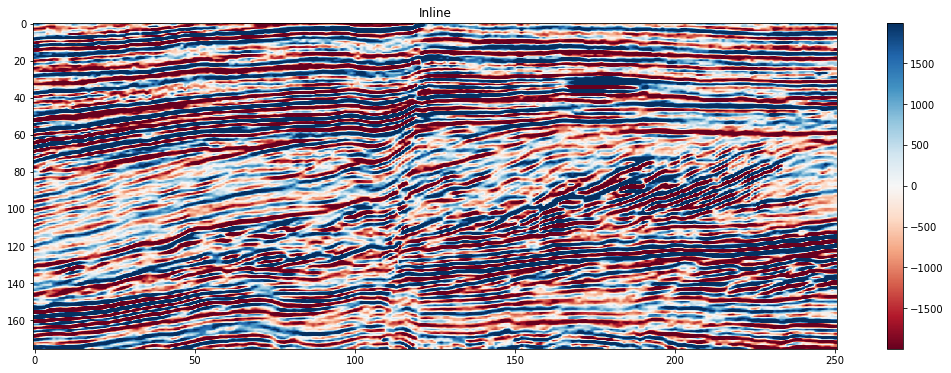

In [30]:
plt.figure(figsize=(18,6))
plt.imshow(obspycube[40,:,:].T, cmap="RdBu", vmin=-1999, vmax=1999, aspect='auto')
plt.colorbar()
plt.title("Inline")
plt.show()

Extract the X and Y coordinates from the 3D cube (obspy object), then plot to check orientations.

Text(0.5, 1.0, 'Northings')

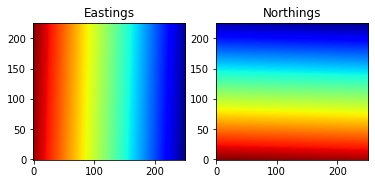

In [31]:
xcord = np.reshape((np.stack(t.header.source_coordinate_x for t in stream.traces)),(226,251,1))
ycord = np.reshape((np.stack(t.header.source_coordinate_y for t in stream.traces)),(226,251,1))

f, axarr = plt.subplots(1,2)
axarr[0].imshow(xcord[:,:,0], cmap = 'jet_r',  origin='lower')
axarr[1].imshow(ycord[:,:,0], cmap = 'jet_r',  origin='lower')
axarr[0].set_title('Eastings')
axarr[1].set_title('Northings')

# Horizon import, plotting and gridding.

In [32]:
from scipy.interpolate import griddata
horizondata = np.loadtxt('pnbsct_hz_by_il_xl.dat')
print('horizondata shape:', horizondata.shape)
hx = ((horizondata[:,0]/2)-np.min((horizondata[:,0]/2))).astype(int)
hy = ((horizondata[:,1]/2)-np.min((horizondata[:,1]/2))).astype(int)
hz = ((horizondata[:,2]-400)*.25)

horizondata shape: (55434, 3)


(226, 251)


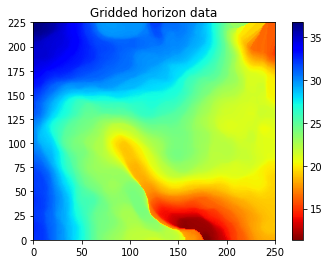

In [33]:
grid_x, grid_y = np.mgrid[0:225:226j,0:250:251j]
grid_z0 = griddata((hx,hy), hz.T, (grid_x, grid_y), method='nearest')
plt.imshow(grid_z0, cmap = 'jet_r', extent=(0,250,0,225), origin='lower')
plt.title('Gridded horizon data')
plt.colorbar()
hzgrid = np.reshape(grid_z0,(226,251,1))

print(grid_z0.shape)

# Compiling 3D seismic amplitudes and interpretation data into Xarray:

For more info, visit Xarray site and see the section called 'Creating a dataset': http://xarray.pydata.org/en/stable/data-structures.html

Load the 3D data into Xarray for simplified coordinate-aware indexing.
* First, define the variables being used as input:

In [34]:
obspycube

northings = ycord[:,0,0]

eastings = xcord[0,:,0]

amps = np.array(obspycube)

t = np.array(np.arange(176))

horizon1twt = hzgrid.T

* Now load data in the same way as Xarray example. Since our objective is to extract a window above and below our interpreted seismic horizon, we will need to enter it to the Xarray as an attribute. For more info, visit Xarray site and see the section called 'Creating a dataset': http://xarray.pydata.org/en/stable/data-structures.html

In [35]:
seisx =  ds = xr.Dataset(
          {
              #"horizon_1_twt": (["inline", "crossline", "time"], hzgrid),
              "amps": (["nting", "eting", "twt"], obspycube),
              "hz": (["nting", "eting"], grid_z0),
              "top": (["nting", "eting"], grid_z0-5),
              "base": (["nting", "eting"], grid_z0+5)
           
           },
           coords={"estings": (["eting"], eastings),
                   "ntings": (["nting"], northings),
                   "t": (["twt"], t)
                   },
                 )
 
seisx

<xarray.Dataset>
Dimensions:  (eting: 251, nting: 226, twt: 176)
Coordinates:
    estings  (eting) int64 6157618 6158118 6158618 ... 6281570 6282070 6282569
    ntings   (nting) int64 60763347 60763847 60764347 ... 60875301 60875801
    t        (twt) int64 0 1 2 3 4 5 6 7 8 ... 168 169 170 171 172 173 174 175
Dimensions without coordinates: eting, nting, twt
Data variables:
    amps     (nting, eting, twt) float32 1014.0 -479.0 -991.0 ... -61.0 2194.0
    hz       (nting, eting) float64 32.42 32.38 32.37 ... 16.14 16.14 16.14
    top      (nting, eting) float64 27.42 27.38 27.37 ... 11.14 11.14 11.14
    base     (nting, eting) float64 37.42 37.38 37.37 ... 21.14 21.14 21.14

Now I have created an Xarray object containing all of my data and attributes, which are listed in the tablular output generated by the command above. I can plot the contents to ensure everything checks out.

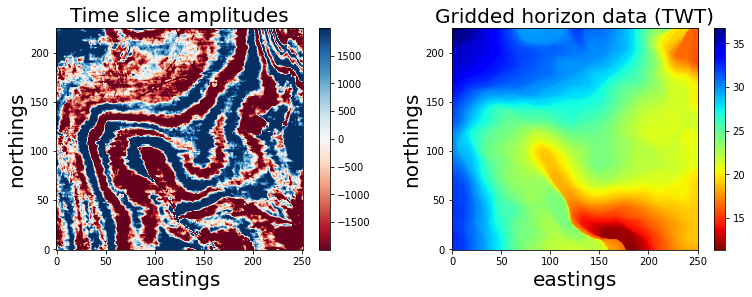

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(11, 4))
im1 = axs[0].imshow(seisx.amps[:,:,40], cmap = 'RdBu', origin='lower',vmin=-1999, vmax=1999, aspect=1)
axs[0].set_xlabel('eastings', fontsize=20)
axs[0].set_ylabel('northings', fontsize=20)
axs[0].set_title('Time slice amplitudes', fontsize=20)
plt.colorbar(im1,ax=axs[0])
im2 = axs[1].imshow(seisx.hz, cmap = 'jet_r', origin='lower', aspect=1)
axs[1].set_xlabel('eastings', fontsize=20)
axs[1].set_ylabel('northings', fontsize=20)
axs[1].set_title('Gridded horizon data (TWT)', fontsize=20)
plt.colorbar(im2,ax=axs[1])
plt.tight_layout()

# Now the training data will be extracted from the seismic


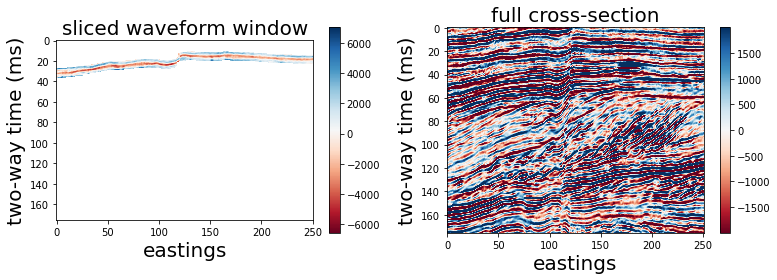

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(11, 4))
im1 = axs[0].imshow(windows.amps[40,:,:].T, cmap = 'RdBu', origin='upper', aspect=1)
axs[0].set_xlabel('eastings', fontsize=20)
axs[0].set_ylabel('two-way time (ms)', fontsize=20)
axs[0].set_title('sliced waveform window', fontsize=20)
plt.colorbar(im1,ax=axs[0])
im2 = axs[1].imshow(obspycube[40,:,:].T, cmap="RdBu", vmin=-1999, vmax=1999, aspect='auto')
axs[1].set_xlabel('eastings', fontsize=20)
axs[1].set_ylabel('two-way time (ms)', fontsize=20)
axs[1].set_title('full cross-section', fontsize=20)
plt.colorbar(im2,ax=axs[1])
plt.tight_layout()

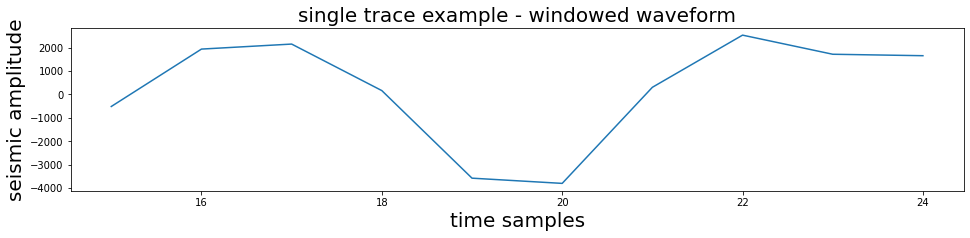

In [38]:
plt.figure(figsize=(16,3))
plt.plot(windows.amps[100,100,:])
plt.title('single trace example - windowed waveform',fontsize=20)
plt.xlabel('time samples', fontsize=20)
plt.ylabel('seismic amplitude', fontsize=20)
plt.show()

convert traces to array:

In [39]:
winarr = np.array(windows.amps)

windata = []
for i in range(winarr.shape[0]):
    for j in range(winarr.shape[1]):
        a = (winarr[i,j])
        b = a.tolist()
        windata.append(b)
windataset = np.array(windata)
windatasetarr = np.reshape(windataset, (251, 226, 176))
windatasetarr[:,:,:].shape
windataset.shape

(56726, 176)

# Datuming the extracted traces for equal comparison:

Currently each trace contains the data within windows that are centered about the z location of the horizon.

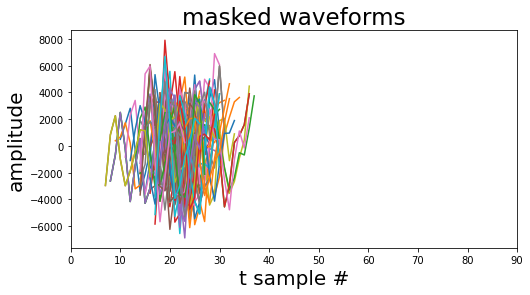

In [40]:
np.random.seed(10)
fig, ax = plt.subplots(figsize=(8, 4))

for i in range(100):
    spike = np.random.randint(0, windatasetarr[40,:].shape[1])
    ax.plot(windatasetarr[spike,60,:])

ax.set_xlim([0, 90])
ax.set_xlabel('t sample #', fontsize=20)
ax.set_ylabel('amplitude', fontsize=20)
ax.set_title('masked waveforms', fontsize=23)
plt.show()

For a fair comparison of traces, the nan values are removed for each trace and the datumed traces are appended in a new array, "tracevals".

In [41]:
wave_form = []

for i in range(windatasetarr.shape[0]):
    for j in range(windatasetarr.shape[1]):
        reals = windatasetarr[[i],[j],:][~np.isnan(windatasetarr[[i],[j],:])]
        wave_form.append(reals)

tracevals = np.reshape(wave_form,(251,226,10))
tracevals.shape

wave_form=np.array([wave_form])
wave_form = wave_form.reshape(56726, 10)
wave_form.shape

(56726, 10)

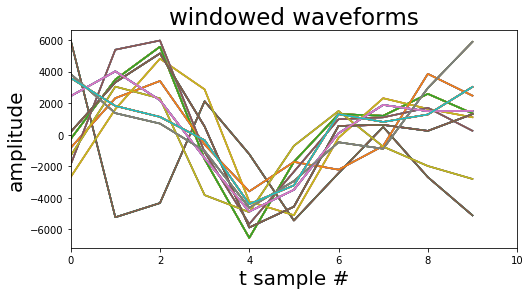

In [42]:
np.random.seed(10)
fig, ax = plt.subplots(figsize=(8, 4))

for i in range(100):
    spike = np.random.randint(0, tracevals[40,:].shape[1])
    ax.plot(tracevals[spike,60,:])

ax.set_xlim([0, 10])
ax.set_xlabel('t sample #', fontsize=20)
ax.set_ylabel('amplitude', fontsize=20)
ax.set_title('windowed waveforms', fontsize=23)
plt.show()

# Simplified K-means test:
https://stackoverflow.com/questions/42398403/python-k-means-clustering-array

In [53]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=7, random_state=0).fit(wave_form)

#you can see the labels with:
print(kmeans.labels_)

[6 6 6 ..., 5 5 5]


Match the class assigned to traces to their corresponding X and Y coordinate origins:

In [54]:
classlist = kmeans.labels_
classes = np.reshape(classlist,(226,251,1))

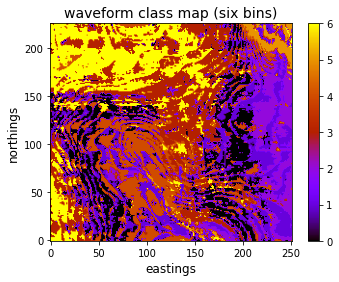

In [55]:
#fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(classes[:,:,0], cmap = 'gnuplot', origin='lower')

plt.xlabel('eastings', fontsize=12)
plt.ylabel('northings', fontsize=12)
plt.title('waveform class map (six bins)', fontsize=14)
plt.colorbar()

# Principal component analysis

In [78]:
# Do PCA
pca = PCA(n_components=4)
pca_result = pca.fit_transform(wave_form[3600:5600])

In [79]:
def k_means(data, num_clus=3, steps=200):

    # Convert data to Numpy array
    cluster_data = np.array(data)
    
    # Initialize by randomly selecting points in the data
    center_init = np.random.randint(0, cluster_data.shape[0], num_clus)

    # Create a list with center coordinates
    center_init = cluster_data[center_init, :]

    # Repeat clustering  x times
    for _ in range(steps):

        # Calculate distance of each data point to cluster center
        distance = []
        for center in center_init:
            tmp_distance = np.sqrt(np.sum((cluster_data - center)**2, axis=1))
            
            # Adding smalle random noise to the data to avoid matching distances to centroids
            tmp_distance = tmp_distance + np.abs(np.random.randn(len(tmp_distance))*0.0001)
            distance.append(tmp_distance)

        # Assign each point to cluster based on minimum distance
        _, cluster = np.where(np.transpose(distance == np.min(distance, axis=0)))

        # Find center of mass for each cluster
        center_init = []
        for i in range(num_clus):    
            center_init.append(cluster_data[cluster == i, :].mean(axis=0).tolist())
            
    return cluster, center_init, distance

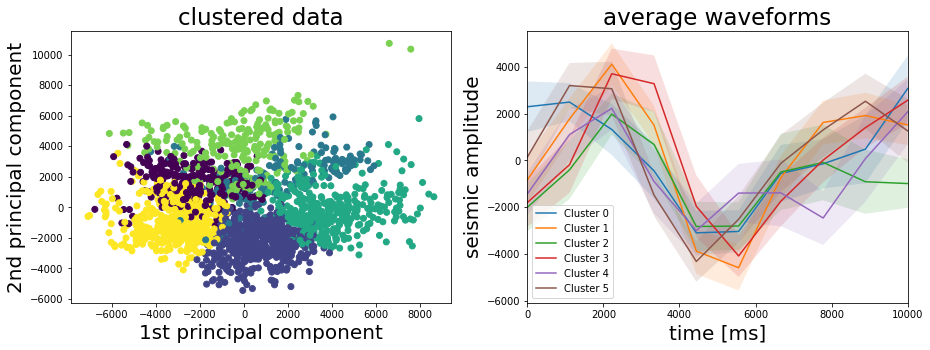

In [80]:
num_clus = 6
cluster, centers, distance = k_means(pca_result, num_clus)

# Plot the result
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].scatter(pca_result[:, 0], pca_result[:, 1], c=cluster)
ax[0].set_xlabel('1st principal component', fontsize=20)
ax[0].set_ylabel('2nd principal component', fontsize=20)
ax[0].set_title('clustered data', fontsize=23)

time = np.linspace(0, wave_form.shape[1], wave_form.shape[1])*1000
for i in range(num_clus):
    cluster_mean = wave_form[3600:5600][cluster==i, :].mean(axis=0)
    cluster_std = wave_form[3600:5600][cluster==i, :].std(axis=0)
    
    ax[1].plot(time, cluster_mean, label='Cluster {}'.format(i))
    ax[1].fill_between(time, cluster_mean-cluster_std, cluster_mean+cluster_std, alpha=0.15)

ax[1].set_title('average waveforms', fontsize=23)
ax[1].set_xlim([0, time[-1]])
ax[1].set_xlabel('time [ms]', fontsize=20)
ax[1].set_ylabel('seismic amplitude', fontsize=20)

plt.legend()
plt.show()